# MIMIC-IV AKI Clustering: Data Preprocessing & Feature Engineering

**Purpose**: Prepare extracted features for clustering analysis
**Input**: `output/aki_clustering_features.csv` (from extraction notebook)
**Output**: Clean, scaled, cluster-ready dataset

**Steps**:
1. Load and inspect data
2. Handle missing data systematically
3. Feature engineering
4. Encode categorical variables
5. Feature selection
6. Scaling and normalization
7. Save preprocessed dataset

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

DATA_DIR = "./clustering_output/data"
RESULT_DIR = "./clustering_output/result"
print("✓ Libraries loaded")

# Load the extracted features
print("Loading extracted features...")
df = pd.read_csv(f"{DATA_DIR}/aki_clustering_features.csv", parse_dates=['aki_time'])

print(f"\n📊 Dataset Overview:")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {df.shape[1]}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✓ Libraries loaded
Loading extracted features...

📊 Dataset Overview:
   Rows: 15,394
   Columns: 72
   Memory: 13.1 MB


## 2. Missing Data Analysis


🔍missing data analysis

Features by missingness category:
  Complete (0% missing):        23
  Low (<10% missing):           24
  Medium (10-30% missing):      8
  High (30-50% missing):        9
  Very high (>50% missing):     8


Top 20 features with missing data:


,feature,missing_pct,missing_count
0,mean_k,74.288684,0
1,max_k,74.288684,0
2,min_k,74.288684,0
3,std_map,50.721060,0
4,shock_index,50.324802,0
5,min_map,50.305314,0
6,max_map,50.305314,0
7,mean_map,50.305314,0
8,mean_bili,46.635053,0
9,max_bili,46.635053,0


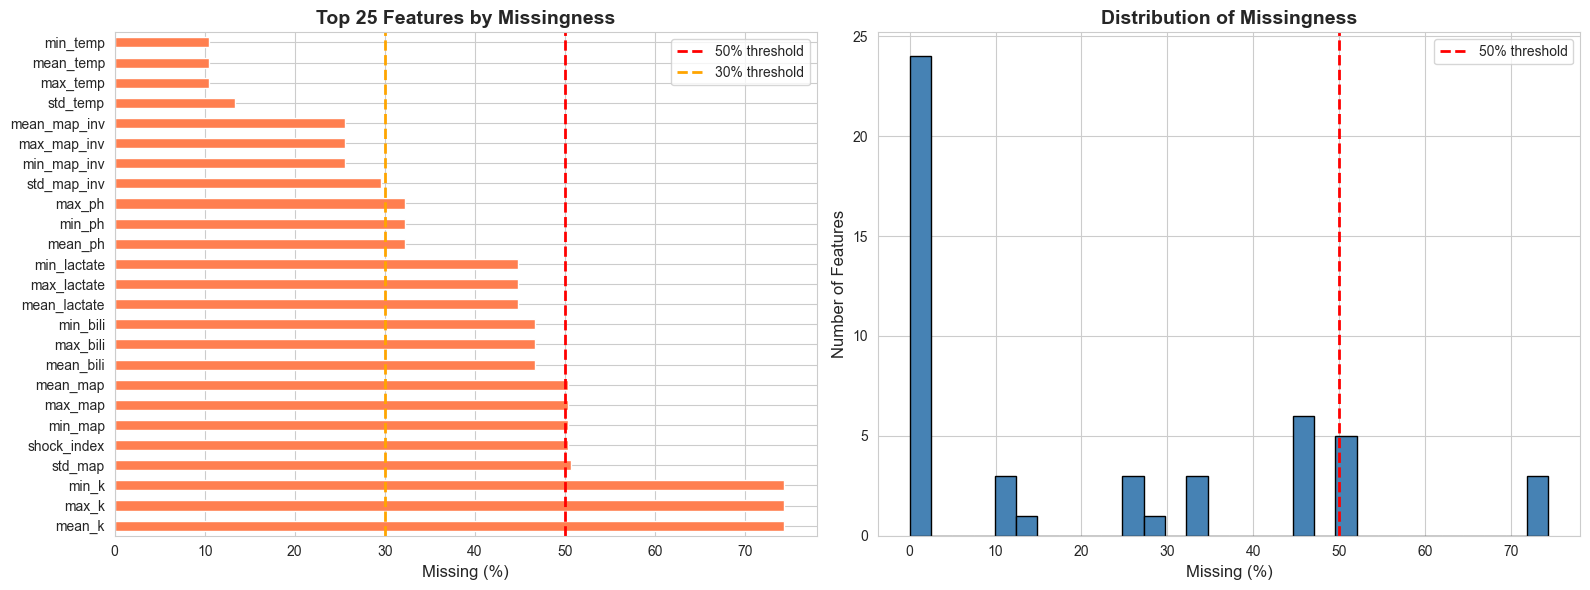


✓ Figure saved to ./clustering_output/result/missingness_analysis.png


In [2]:
print("\n🔍missing data analysis\n" + "="*60)

# Calculate missingness
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'feature': missing.index,
    'missing_pct': missing.values,
    'missing_count': df.isnull().sum().values
})

print("\nFeatures by missingness category:")
print(f"  Complete (0% missing):        {(missing == 0).sum()}")
print(f"  Low (<10% missing):           {((missing > 0) & (missing < 10)).sum()}")
print(f"  Medium (10-30% missing):      {(missing.between(10, 30)).sum()}")
print(f"  High (30-50% missing):        {(missing.between(30, 50)).sum()}")
print(f"  Very high (>50% missing):     {(missing > 50).sum()}")

print("\n\nTop 20 features with missing data:")
display(missing_df.head(20))

# %%
# Visualize missingness pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top missing features
top_missing = missing[missing > 0].head(25)
top_missing.plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_xlabel('Missing (%)', fontsize=12)
axes[0].set_title('Top 25 Features by Missingness', fontsize=14, fontweight='bold')
axes[0].axvline(50, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[0].axvline(30, color='orange', linestyle='--', linewidth=2, label='30% threshold')
axes[0].legend()

# Histogram of missingness distribution
missing[missing > 0].plot(kind='hist', bins=30, ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Missing (%)', fontsize=12)
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Distribution of Missingness', fontsize=14, fontweight='bold')
axes[1].axvline(50, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/missingness_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to {RESULT_DIR}/missingness_analysis.png")

## 3. Refining hemodynamics: coalescing map measurements

In [3]:
print("\n💉 Refining hemodynamics: coalescing map measurements\n" + "="*60)

# The goal is to create a unified MAP feature
# We prioritize 'invasive' if available, otherwise use 'non-invasive'
map_pairs = {
    'mean_map_combined': ('mean_map_inv', 'mean_map'),
    'min_map_combined': ('min_map_inv', 'min_map'),
    'max_map_combined': ('max_map_inv', 'max_map')
}

for combined_col, (inv_col, noninv_col) in map_pairs.items():
    if inv_col in df.columns and noninv_col in df.columns:
        # Coalesce: Fill missing invasive values with non-invasive values
        df[combined_col] = df[inv_col].fillna(df[noninv_col])
        
        # Calculate new missingness for the combined column
        new_missing = df[combined_col].isna().sum() / len(df) * 100
        print(f"  ✓ Created {combined_col}: {new_missing:.1f}% missing (Unified)")
        
        # Drop the original separate columns to avoid redundancy/high missingness
        df = df.drop(columns=[inv_col, noninv_col])
        print(f"    → Dropped original {inv_col} and {noninv_col}")


print(f"\n✓ Unified MAP features created. New dataset shape: {df.shape}")


💉 Refining hemodynamics: coalescing map measurements
  ✓ Created mean_map_combined: 2.6% missing (Unified)
    → Dropped original mean_map_inv and mean_map
  ✓ Created min_map_combined: 2.6% missing (Unified)
    → Dropped original min_map_inv and min_map
  ✓ Created max_map_combined: 2.6% missing (Unified)
    → Dropped original max_map_inv and max_map

✓ Unified MAP features created. New dataset shape: (15394, 69)


## 4. Handle Duplicate Features (Potassium)

In [4]:
print("\n🔧 HANDLING DUPLICATE FEATURES\n" + "="*60)

# Check for duplicate potassium columns (different itemids)
k_cols = [col for col in df.columns if 'k' in col.lower() and any(x in col for x in ['mean_', 'max_', 'min_'])]
k_cols = [col for col in k_cols if col not in ['shock_index']]  # Exclude shock_index

if k_cols:
    print(f"\nPotassium columns found: {k_cols}")
    for col in k_cols:
        missing_pct = df[col].isnull().sum() / len(df) * 100
        print(f"  {col}: {missing_pct:.1f}% missing")
    
    # Identify which to drop (>70% missing)
    k_to_drop = [col for col in k_cols if df[col].isnull().sum() / len(df) * 100 > 70]
    
    if k_to_drop:
        print(f"\n  → Dropping high-missing potassium columns: {k_to_drop}")
        df = df.drop(columns=k_to_drop)
        print(f"  ✓ Dropped {len(k_to_drop)} columns")
else:
    print("No duplicate potassium columns found")

print(f"\n✓ Dataset shape after duplicate removal: {df.shape}")


🔧 HANDLING DUPLICATE FEATURES

Potassium columns found: ['mean_k', 'min_k', 'max_k']
  mean_k: 74.3% missing
  min_k: 74.3% missing
  max_k: 74.3% missing

  → Dropping high-missing potassium columns: ['mean_k', 'min_k', 'max_k']
  ✓ Dropped 3 columns

✓ Dataset shape after duplicate removal: (15394, 66)


## 5. Create Missingness Indicator Features

In [5]:
print("\n📊 CREATING MISSINGNESS INDICATORS\n" + "="*60)

# Create binary indicators for clinically meaningful missing data
missingness_indicators = {
    'has_map_monitoring': 'mean_map',
    'has_lactate': 'max_lactate', 
    'has_bilirubin': 'max_bili',
    'has_abg': 'mean_ph',
    'has_hemoglobin': 'min_hgb',
    'has_platelet': 'min_plt'
}

indicators_created = []
for indicator_name, source_col in missingness_indicators.items():
    if source_col in df.columns:
        df[indicator_name] = (~df[source_col].isna()).astype(int)
        indicators_created.append(indicator_name)
        pct_measured = df[indicator_name].mean() * 100
        print(f"  ✓ {indicator_name}: {pct_measured:.1f}% of patients")

print(f"\n✓ Created {len(indicators_created)} missingness indicators")


📊 CREATING MISSINGNESS INDICATORS
  ✓ has_lactate: 55.2% of patients
  ✓ has_bilirubin: 53.4% of patients
  ✓ has_abg: 67.7% of patients
  ✓ has_hemoglobin: 99.6% of patients
  ✓ has_platelet: 99.6% of patients

✓ Created 5 missingness indicators


## 6. Feature Engineering

In [6]:
print("\n🔬 FEATURE ENGINEERING\n" + "="*60)

# Calculate derived features
print("\nCreating derived features...")

# 1. AKI severity metrics (if not already present)
if 'cr_fold_change' not in df.columns and 'aki_cr' in df.columns and 'baseline_cr' in df.columns:
    df['cr_fold_change'] = df['aki_cr'] / df['baseline_cr']
    print("  ✓ cr_fold_change")

if 'cr_change_pct' not in df.columns and 'aki_cr' in df.columns and 'baseline_cr' in df.columns:
    df['cr_change_pct'] = (df['aki_cr'] - df['baseline_cr']) / df['baseline_cr'] * 100
    print("  ✓ cr_change_pct")

# 2. Shock index (if not present)
if 'shock_index' not in df.columns and 'mean_hr' in df.columns and 'mean_map' in df.columns:
    df['shock_index'] = df['mean_hr'] / df['mean_map'].replace(0, np.nan)
    print("  ✓ shock_index")

# 3. BUN/Cr ratio (if not present)
if 'bun_cr_ratio' not in df.columns and 'mean_bun' in df.columns and 'mean_cr' in df.columns:
    df['bun_cr_ratio'] = df['mean_bun'] / df['mean_cr'].replace(0, np.nan)
    print("  ✓ bun_cr_ratio")

# 4. Comorbidity burden score
comorbidity_cols = ['chf', 'hypertension', 'diabetes', 'ckd', 'liver_disease', 'copd', 'malignancy']
comorbidity_cols = [col for col in comorbidity_cols if col in df.columns]
if comorbidity_cols:
    df['comorbidity_count'] = df[comorbidity_cols].sum(axis=1)
    print("  ✓ comorbidity_count")

# 5. Age categories
if 'age' in df.columns:
    df['age_category'] = pd.cut(df['age'], bins=[0, 40, 60, 75, 120], 
                                  labels=['young', 'middle', 'elderly', 'very_elderly'])
    print("  ✓ age_category")

# 6. MAP adequacy (if MAP available)
if 'mean_map' in df.columns:
    df['hypotensive'] = (df['mean_map'] < 65).astype(int)  # MAP <65 = hypotension
    print("  ✓ hypotensive indicator")

# 7. Oliguria proxy (if available)
if 'min_plt' in df.columns:
    df['thrombocytopenia'] = (df['min_plt'] < 150).astype(int)  # Platelet <150k
    print("  ✓ thrombocytopenia indicator")

print(f"\n✓ Dataset shape after feature engineering: {df.shape}")


🔬 FEATURE ENGINEERING

Creating derived features...
  ✓ comorbidity_count
  ✓ age_category
  ✓ thrombocytopenia indicator

✓ Dataset shape after feature engineering: (15394, 74)


## 6. Separate Features by Type

In [7]:
print("\n📋 FEATURE CATEGORIZATION\n" + "="*60)

# Identify different feature types
identifier_cols = ['stay_id', 'aki_time']
target_cols = ['aki_stage']  # Could be used for validation later

# Categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in identifier_cols]

# Numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in identifier_cols + target_cols]

# Binary features (including comorbidities and missingness indicators)
binary_cols = [col for col in numeric_cols if df[col].dropna().isin([0, 1]).all()]

# Continuous features (excluding binary)
continuous_cols = [col for col in numeric_cols if col not in binary_cols]

print(f"\nFeature types:")
print(f"  Identifiers:          {len(identifier_cols)}")
print(f"  Target (AKI stage):   {len(target_cols)}")
print(f"  Categorical:          {len(categorical_cols)}")
print(f"  Binary:               {len(binary_cols)}")
print(f"  Continuous:           {len(continuous_cols)}")
print(f"  Total:                {len(identifier_cols) + len(target_cols) + len(categorical_cols) + len(numeric_cols)}")

print(f"\nCategorical features: {categorical_cols}")
print(f"\nBinary features: {binary_cols}")
print(f"\nContinuous features: {continuous_cols}")


📋 FEATURE CATEGORIZATION

Feature types:
  Identifiers:          2
  Target (AKI stage):   1
  Categorical:          6
  Binary:               13
  Continuous:           52
  Total:                74

Categorical features: ['first_careunit', 'gender', 'race', 'admission_type', 'admission_location', 'age_category']

Binary features: ['chf', 'hypertension', 'diabetes', 'ckd', 'liver_disease', 'copd', 'malignancy', 'has_lactate', 'has_bilirubin', 'has_abg', 'has_hemoglobin', 'has_platelet', 'thrombocytopenia']

Continuous features: ['baseline_cr', 'aki_cr', 'age', 'mean_hr', 'mean_rr', 'mean_temp', 'min_hr', 'min_rr', 'min_temp', 'max_hr', 'max_rr', 'max_temp', 'std_hr', 'std_map', 'std_map_inv', 'std_rr', 'std_temp', 'mean_bili', 'mean_bun', 'mean_cr', 'mean_hco3', 'mean_hgb', 'mean_lactate', 'mean_ph', 'mean_plt', 'mean_wbc', 'min_bili', 'min_bun', 'min_cr', 'min_hco3', 'min_hgb', 'min_lactate', 'min_ph', 'min_plt', 'min_wbc', 'max_bili', 'max_bun', 'max_cr', 'max_hco3', 'max_hgb', 'ma

## 7. Handle Missing Data in Continuous Features

In [8]:
print("\n💉 MISSING DATA IMPUTATION\n" + "="*60)

# Separate by missingness level
missing_pcts = df[continuous_cols].isnull().sum() / len(df) * 100

low_missing_features = missing_pcts[missing_pcts < 10].index.tolist()
med_missing_features = missing_pcts[missing_pcts.between(10, 30)].index.tolist()
high_missing_features = missing_pcts[missing_pcts.between(30, 50)].index.tolist()
very_high_missing = missing_pcts[missing_pcts >= 50].index.tolist()

print(f"\nContinuous features by missingness:")
print(f"  Low (<10%):          {len(low_missing_features)}")
print(f"  Medium (10-30%):     {len(med_missing_features)}")
print(f"  High (30-50%):       {len(high_missing_features)}")
print(f"  Very high (≥50%):    {len(very_high_missing)}")

# Strategy 1: Drop features with >50% missing
if very_high_missing:
    print(f"\n  → Dropping {len(very_high_missing)} features with >50% missing:")
    print(f"     {very_high_missing}")
    df = df.drop(columns=very_high_missing)
    continuous_cols = [col for col in continuous_cols if col not in very_high_missing]

# Strategy 2: Median imputation for low-medium missing (<30%)
low_med_features = [col for col in continuous_cols if col in low_missing_features + med_missing_features]
if low_med_features:
    print(f"\n  → Median imputation for {len(low_med_features)} features (<30% missing)")
    imputer_median = SimpleImputer(strategy='median')
    df[low_med_features] = imputer_median.fit_transform(df[low_med_features])
    print(f"     ✓ Imputed")

# Strategy 3: KNN imputation for high missing (30-50%)
high_features = [col for col in continuous_cols if col in high_missing_features]
if high_features:
    print(f"\n  → KNN imputation for {len(high_features)} features (30-50% missing)")
    print(f"     Features: {high_features}")
    
    # Use all low-medium features as predictors for KNN
    predictor_cols = low_med_features[:20]  # Use top 20 to avoid curse of dimensionality
    knn_features = predictor_cols + high_features
    
    imputer_knn = KNNImputer(n_neighbors=5, weights='distance')
    df[knn_features] = imputer_knn.fit_transform(df[knn_features])
    print(f"     ✓ Imputed using {len(predictor_cols)} predictor features")

# Handle any remaining missing in continuous features
remaining_missing = df[continuous_cols].isnull().sum().sum()
if remaining_missing > 0:
    print(f"\n  ⚠ Warning: {remaining_missing} missing values remain in continuous features")
    print(f"     Applying median imputation to remaining...")
    imputer_final = SimpleImputer(strategy='median')
    df[continuous_cols] = imputer_final.fit_transform(df[continuous_cols])

print(f"\n✓ Missing data imputation complete")
print(f"  Remaining missing values in continuous features: {df[continuous_cols].isnull().sum().sum()}")



💉 MISSING DATA IMPUTATION

Continuous features by missingness:
  Low (<10%):          36
  Medium (10-30%):     5
  High (30-50%):       9
  Very high (≥50%):    2

  → Dropping 2 features with >50% missing:
     ['std_map', 'shock_index']

  → Median imputation for 41 features (<30% missing)
     ✓ Imputed

  → KNN imputation for 9 features (30-50% missing)
     Features: ['mean_bili', 'mean_lactate', 'mean_ph', 'min_bili', 'min_lactate', 'min_ph', 'max_bili', 'max_lactate', 'max_ph']
     ✓ Imputed using 20 predictor features

✓ Missing data imputation complete
  Remaining missing values in continuous features: 0


## 8. Encode Categorical Variables

In [9]:
print("\n🔤 ENCODING CATEGORICAL VARIABLES\n" + "="*60)

# One-hot encode categorical features
if categorical_cols:
    print(f"\nOne-hot encoding {len(categorical_cols)} categorical features:")
    
    for col in categorical_cols:
        n_categories = df[col].nunique()
        print(f"  {col}: {n_categories} categories")
    
    # One-hot encode
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
    
    # Identify new dummy columns
    new_dummy_cols = [col for col in df_encoded.columns if col not in df.columns]
    
    print(f"\n  ✓ Created {len(new_dummy_cols)} dummy variables")
    print(f"  ✓ Dataset shape: {df_encoded.shape}")
    
    df = df_encoded
else:
    print("No categorical variables to encode")

binary_cols.extend(new_dummy_cols)


🔤 ENCODING CATEGORICAL VARIABLES

One-hot encoding 6 categorical features:
  first_careunit: 15 categories
  gender: 2 categories
  race: 33 categories
  admission_type: 8 categories
  admission_location: 10 categories
  age_category: 4 categories

  ✓ Created 66 dummy variables
  ✓ Dataset shape: (15394, 132)


## 9. Feature Selection & Variance Filtering

In [10]:
print("\n🎯 FEATURE SELECTION\n" + "="*60)

# Identify features for clustering (exclude identifiers and target)
clustering_features = [col for col in df.columns if col not in identifier_cols + target_cols]

print(f"\nTotal clustering features: {len(clustering_features)}")

# Remove zero-variance features
print("\n  Checking for zero-variance features...")
variance_filter = VarianceThreshold(threshold=0.0)
df_variance = df[clustering_features].copy()

# Fit and identify zero-variance columns
variance_filter.fit(df_variance)
zero_var_mask = variance_filter.get_support()
zero_var_features = df_variance.columns[~zero_var_mask].tolist()

if zero_var_features:
    print(f"  → Removing {len(zero_var_features)} zero-variance features:")
    print(f"     {zero_var_features}")
    clustering_features = [col for col in clustering_features if col not in zero_var_features]
    df = df.drop(columns=zero_var_features)
else:
    print("  ✓ No zero-variance features found")

# Check for high correlation (>0.95) and remove redundant features
print("\n  Checking for highly correlated features (r > 0.95)...")
numeric_clustering = [col for col in clustering_features if col in df.select_dtypes(include=[np.number]).columns]

if len(numeric_clustering) > 1:
    corr_matrix = df[numeric_clustering].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    if high_corr_features:
        print(f"  → Removing {len(high_corr_features)} highly correlated features:")
        for feat in high_corr_features:
            corr_pairs = upper_tri[feat][upper_tri[feat] > 0.95]
            print(f"     {feat}: correlated with {corr_pairs.index.tolist()}")
        
        clustering_features = [col for col in clustering_features if col not in high_corr_features]
        df = df.drop(columns=high_corr_features)
    else:
        print("  ✓ No highly correlated features found")

print(f"\n✓ Final clustering features: {len([col for col in df.columns if col in clustering_features])}")



🎯 FEATURE SELECTION

Total clustering features: 129

  Checking for zero-variance features...
  ✓ No zero-variance features found

  Checking for highly correlated features (r > 0.95)...
  → Removing 19 highly correlated features:
     max_temp: correlated with ['mean_temp']
     std_temp: correlated with ['mean_temp', 'max_temp']
     mean_cr: correlated with ['aki_cr']
     min_bili: correlated with ['mean_bili']
     min_bun: correlated with ['mean_bun']
     min_cr: correlated with ['mean_cr']
     min_hco3: correlated with ['mean_hco3']
     min_hgb: correlated with ['mean_hgb']
     min_plt: correlated with ['mean_plt']
     min_wbc: correlated with ['mean_wbc']
     max_bili: correlated with ['mean_bili', 'min_bili']
     max_bun: correlated with ['mean_bun']
     max_cr: correlated with ['aki_cr', 'mean_cr']
     max_hco3: correlated with ['mean_hco3']
     max_hgb: correlated with ['mean_hgb']
     max_lactate: correlated with ['mean_lactate']
     max_plt: correlated with ['

## 10. Feature Scaling

In [11]:
print("\n📏 FEATURE SCALING\n" + "="*60)

# Separate features that need scaling (continuous) from those that don't (binary)
features_to_scale = [col for col in clustering_features 
                     if col in df.columns and col not in binary_cols]

print(f"\nFeatures to scale (continuous): {len(features_to_scale)}")
print(f"Features to keep as-is (binary): {len([col for col in clustering_features if col in binary_cols])}")

# Use RobustScaler (less sensitive to outliers than StandardScaler)
if features_to_scale:
    scaler = RobustScaler()
    df_scaled = df.copy()
    df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    
    print("\n  ✓ Applied RobustScaler to continuous features")
    print("     (Robust to outliers, uses median and IQR)")
    
    # Save the scaler for later use
    import joblib
    joblib.dump(scaler, f"{DATA_DIR}/scaler.pkl")
    print(f"     ✓ Saved scaler to {DATA_DIR}/scaler.pkl")
else:
    df_scaled = df.copy()
    print("\n  No continuous features to scale")


📏 FEATURE SCALING

Features to scale (continuous): 31
Features to keep as-is (binary): 79

  ✓ Applied RobustScaler to continuous features
     (Robust to outliers, uses median and IQR)
     ✓ Saved scaler to ./clustering_output/data/scaler.pkl


## 11. Final Dataset Summary

In [12]:
print("\n📊 FINAL PREPROCESSED DATASET SUMMARY\n" + "="*60)

# Create final clustering dataset
final_clustering_features = [col for col in df_scaled.columns if col in clustering_features]
df_final = df_scaled[identifier_cols + target_cols + final_clustering_features].copy()

print(f"\nDataset dimensions:")
print(f"  Patients (rows):           {len(df_final):,}")
print(f"  Total columns:             {df_final.shape[1]}")
print(f"  Clustering features:       {len(final_clustering_features)}")

print(f"\nFeature breakdown:")
print(f"  Binary features:           {len([col for col in final_clustering_features if col in binary_cols])}")
print(f"  Continuous features:       {len([col for col in final_clustering_features if col not in binary_cols])}")

print(f"\nData quality:")
print(f"  Missing values:            {df_final[final_clustering_features].isnull().sum().sum()}")
print(f"  Infinite values:           {np.isinf(df_final[final_clustering_features].select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Duplicate rows:            {df_final.duplicated().sum()}")

# Show feature list
print(f"\n📋 Final clustering features ({len(final_clustering_features)}):")
for i, feat in enumerate(final_clustering_features, 1):
    print(f"  {i:2d}. {feat}")


📊 FINAL PREPROCESSED DATASET SUMMARY

Dataset dimensions:
  Patients (rows):           15,394
  Total columns:             113
  Clustering features:       110

Feature breakdown:
  Binary features:           79
  Continuous features:       31

Data quality:
  Missing values:            0
  Infinite values:           0
  Duplicate rows:            1718

📋 Final clustering features (110):
   1. baseline_cr
   2. aki_cr
   3. age
   4. chf
   5. hypertension
   6. diabetes
   7. ckd
   8. liver_disease
   9. copd
  10. malignancy
  11. mean_hr
  12. mean_rr
  13. mean_temp
  14. min_hr
  15. min_rr
  16. min_temp
  17. max_hr
  18. max_rr
  19. std_hr
  20. std_map_inv
  21. std_rr
  22. mean_bili
  23. mean_bun
  24. mean_hco3
  25. mean_hgb
  26. mean_lactate
  27. mean_ph
  28. mean_plt
  29. mean_wbc
  30. min_lactate
  31. min_ph
  32. max_ph
  33. bun_cr_ratio
  34. cr_fold_change
  35. mean_map_combined
  36. min_map_combined
  37. max_map_combined
  38. has_lactate
  39. has_bil

## 12. Save Preprocessed Data

In [13]:
print("\n💾 SAVING PREPROCESSED DATA\n" + "="*60)

# Save full dataset (with identifiers)
df_final.to_csv(f"{DATA_DIR}/aki_preprocessed_full.csv", index=False)
print(f"✓ Saved full dataset: {DATA_DIR}/aki_preprocessed_full.csv")

# Save clustering-ready dataset (features only)
df_clustering = df_final[final_clustering_features].copy()
df_clustering.to_csv(f"{DATA_DIR}/aki_clustering_ready.csv", index=False)
print(f"✓ Saved clustering-ready: {DATA_DIR}/aki_clustering_ready.csv")

# Save feature metadata
feature_metadata = pd.DataFrame({
    'feature': final_clustering_features,
    'type': ['binary' if col in binary_cols else 'continuous' for col in final_clustering_features],
    'missingness_pct_original': [missing.get(col, 0) for col in final_clustering_features]
})
feature_metadata.to_csv(f"{DATA_DIR}/feature_metadata.csv", index=False)
print(f"✓ Saved feature metadata: {DATA_DIR}/feature_metadata.csv")

# Save identifiers mapping
id_mapping = df_final[identifier_cols + target_cols].copy()
id_mapping.to_csv(f"{DATA_DIR}/patient_identifiers.csv", index=False)
print(f"✓ Saved patient identifiers: {DATA_DIR}/patient_identifiers.csv")


💾 SAVING PREPROCESSED DATA
✓ Saved full dataset: ./clustering_output/data/aki_preprocessed_full.csv
✓ Saved clustering-ready: ./clustering_output/data/aki_clustering_ready.csv
✓ Saved feature metadata: ./clustering_output/data/feature_metadata.csv
✓ Saved patient identifiers: ./clustering_output/data/patient_identifiers.csv


## 13. Final Visualizations


📈 GENERATING FINAL VISUALIZATIONS


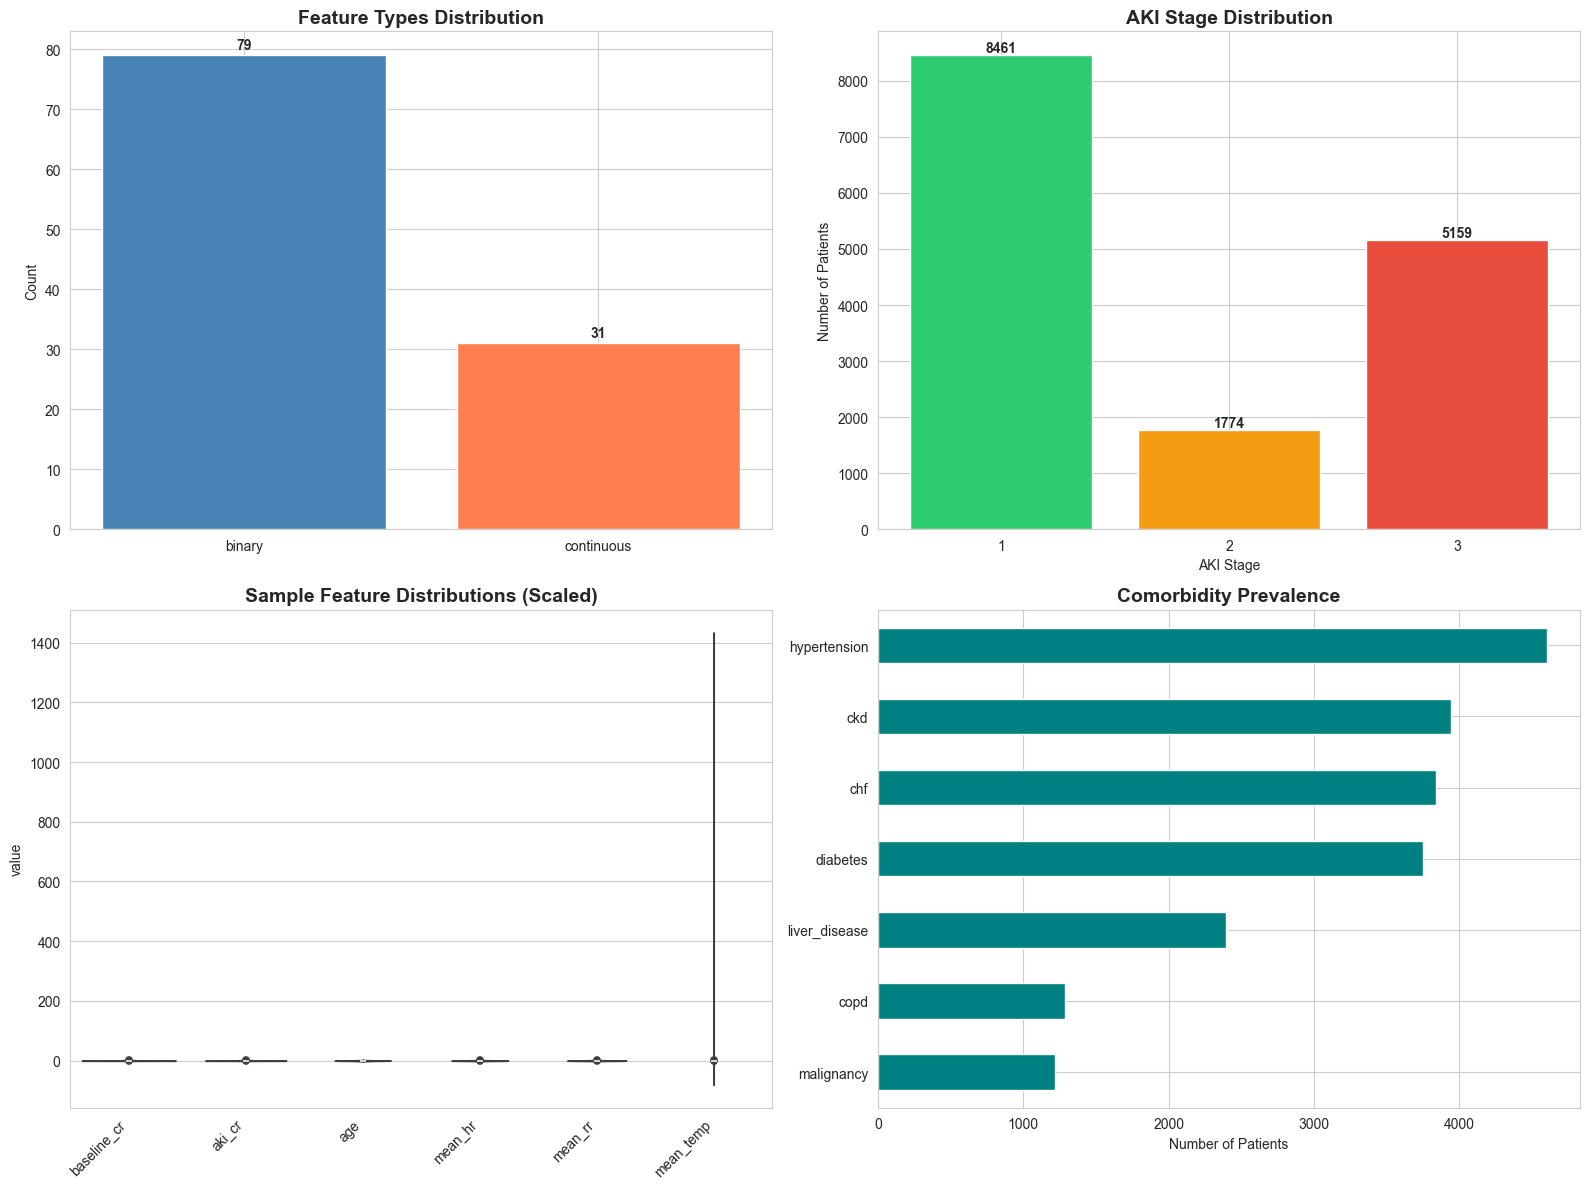

✓ Figure saved to ./clustering_output/result/preprocessing_summary.png

✅ PREPROCESSING COMPLETE!

📁 Output files created:
   1. aki_preprocessed_full.csv       - Full dataset with IDs
   2. aki_clustering_ready.csv        - Features only (for clustering)
   3. feature_metadata.csv            - Feature descriptions
   4. patient_identifiers.csv         - ID mapping
   5. scaler.pkl                      - Fitted scaler object
   6. preprocessing_summary.png       - Visualization

🎯 Next step: Run clustering algorithms!


In [14]:
print("\n📈 GENERATING FINAL VISUALIZATIONS\n" + "="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature types distribution
feature_types = feature_metadata['type'].value_counts()
axes[0, 0].bar(feature_types.index, feature_types.values, color=['steelblue', 'coral'])
axes[0, 0].set_title('Feature Types Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(feature_types.values):
    axes[0, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 2. AKI stage distribution
stage_dist = df_final['aki_stage'].value_counts().sort_index()
axes[0, 1].bar(stage_dist.index, stage_dist.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0, 1].set_title('AKI Stage Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('AKI Stage')
axes[0, 1].set_ylabel('Number of Patients')
axes[0, 1].set_xticks([1, 2, 3])
for i, v in enumerate(stage_dist.values):
    axes[0, 1].text(i+1, v + 50, str(v), ha='center', fontweight='bold')

# 3. Sample feature distributions (continuous)
continuous_sample = [col for col in final_clustering_features if col not in binary_cols][:6]
if continuous_sample:
    sample_data = df_final[continuous_sample].melt()
    sns.violinplot(data=sample_data, x='variable', y='value', ax=axes[1, 0])
    axes[1, 0].set_title('Sample Feature Distributions (Scaled)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
else:
    axes[1, 0].text(0.5, 0.5, 'No continuous features', ha='center', va='center')
    axes[1, 0].set_title('Sample Feature Distributions', fontsize=14, fontweight='bold')

# 4. Comorbidity prevalence
comorbidity_prevalence = df_final[comorbidity_cols].sum().sort_values(ascending=True)
comorbidity_prevalence.plot(kind='barh', ax=axes[1, 1], color='teal')
axes[1, 1].set_title('Comorbidity Prevalence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Patients')

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/preprocessing_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to {RESULT_DIR}/preprocessing_summary.png")

# %%
print("\n" + "="*70)
print("✅ PREPROCESSING COMPLETE!")
print("="*70)
print(f"\n📁 Output files created:")
print(f"   1. aki_preprocessed_full.csv       - Full dataset with IDs")
print(f"   2. aki_clustering_ready.csv        - Features only (for clustering)")
print(f"   3. feature_metadata.csv            - Feature descriptions")
print(f"   4. patient_identifiers.csv         - ID mapping")
print(f"   5. scaler.pkl                      - Fitted scaler object")
print(f"   6. preprocessing_summary.png       - Visualization")
print(f"\n🎯 Next step: Run clustering algorithms!")
print("="*70)